## Import

In [17]:
import pandas as pd
from abc import ABC, abstractmethod
import transformers
import torch
import json
import ast
import numpy as np
import time

import datasets
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel
import torch

from transformers import (
    BertForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)
from transformers import AutoTokenizer, AutoModelForTokenClassification

## Model init

In [5]:
conf = {#"load_in_4bit": False,
        #"load_in_8bit": False,
        #"model_name": "Qwen/Qwen3-1.7B",
        "cache_dir": "G:\\My_files\\Programming\\My_projects\\LLM\\Models", 
        "device": "cuda"}

In [6]:
#Еще варианты:
# Use a pipeline as a high-level helper
#from transformers import pipeline

#pipe = pipeline("token-classification", model="Gherman/bert-base-NER-Russian")     # Load model directly

#model_name = "ai-forever/ruElectra-small"
#model_name = "ai-forever/ruElectra-medium"
#model_name = "ai-forever/ruElectra-large"
#model_name = "Gherman/bert-base-NER-Russian"
#model_name = "ai-forever/sbert_large_mt_nlu_ru"
#model_name = "ai-forever/sbert_large_nlu_ru"
model_name = "DeepPavlov/rubert-base-cased"
#model_name = "yqelz/xml-roberta-large-ner-russian"

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          cache_dir=conf['cache_dir'])
model = AutoModelForTokenClassification.from_pretrained(model_name,#"Gherman/bert-base-NER-Russian", 
                                                        cache_dir=conf['cache_dir'],
                                                        num_labels=num_labels,
                                                        id2label=int_to_bio,
                                                        label2id=bio_to_int)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data

In [4]:
int_to_bio = {0: 'B-BRAND',
                1: 'B-TYPE',
                2: 'B-VOLUME',
                3: 'I-PERCENT',
                4: 'B-PERCENT',
                5: 'I-VOLUME',
                6: 'I-TYPE',
                7: 'I-BRAND',
                8: 'O'}
bio_to_int = {v:k for k,v in int_to_bio.items()}
num_labels=len(list(int_to_bio.values()))

Tokenizer for data

### Synth generation

In [68]:
alphanumeric_list = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 
                    'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 
                    'ы', 'ь', 'э', 'ю', 'я', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 
                    'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 
                    'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', '0', '1', '2', '3', 
                    '4', '5', '6', '7', '8', '9', '', ' ', '  ']
volumes = [
    "0.25 л", "0.33 л", "0.5 л", "0.7 л", "1 л", "1.5 л", "2 л", "5 л", "2.99 л", "1.8 Л", "1.95Л",
    "100 г", "200 г", "250 г", "300 г", "400 г", "450 г", "500 г", "750 г",'1шт'
    "800 г", "900 г", "1 кг", "1.5 кг", "2 кг", "5 кг", "10 шт", "20 шт", "30 шт",'100 штук', '250.0 g', 
]

percents = ["0.5%", "1%", "1.5%", "2%", "2.5%", "3.2%", "5%", "7%", "9%", "10%", "12%", "15%", "5проц", "7проц", "9пр", "0.1%", "0.12пр", "15 процентов","20%", "25%", "30%", "45%", "50процентов"]

# Шумовые слова (O)
noise_words = ["дешево", "подешевле", "получше", "подороже", "хорошее", "купить", "заказать", "онлайн", "недорого", "доставка", "в магазине", "по акции", " ", "1", "  ", "/", "-", "    ", "хочу", "быстро", "на дом"]

types = list(set([
    "молоко", "хлеб", "батон", "чипсы", "вода", "сметана", "кефир", "йогурт", "сыр", "масло",
    "печенье", "шоколад", "пельмени", "сок", "напиток энергетический", "колбаса",
    "минеральная вода", "томатная паста", "яйца куриные", "каша", "чай", "кофе",
    "макароны", "спагетти", "рис", "гречка", "овсянка", "пицца", "суши", "бургер", "сэндвич",
    "ice cream", "cookies", "chocolate", "beer", "wine", "whiskey", "vodka",
    "pasta", "rice", "noodles", "sushi", "burger", "sandwich", "juice", "energy drink",
    "молоко", "хлеб", "батон", "чипсы", "вода", "сметана", "кефир", "йогурт",
    "сыр", "масло сливочное", "печенье", "шоколад", "пельмени", "сок апельсиновый",
    "напиток энергетический", "колбаса вареная", "минеральная вода", "томатная паста",
    "яйца куриные", "каша овсяная", "чай зеленый", "кофе молотый", 
    "молоко", "хлеб", "батон", "чипсы", "вода", "сметана", "кефир", "йогурт",
    "сыр", "масло сливочное", "печенье", "шоколад", "пельмени", "сок апельсиновый",
    "напиток энергетический", "колбаса вареная", "минеральная вода", "томатная паста",
    "яйца куриные", "каша овсяная", "чай зеленый", "кофе молотый",     # Продовольственные товары
    "Крупы и бобовые", "Мука и макаронные изделия", "Хлебобулочные изделия", "Сухие завтраки", 
    "Специи и приправы", "Чай и кофе", "Соль и сахар", "Молоко и молочные напитки",
    "Кисломолочные продукты", "Сыры", "Сливочное масло", "Творог и творожные изделия",
    "Мороженое", "Свежее мясо", "Колбасные изделия",
    "Мясные полуфабрикаты", "Мясные консервы", "Куриные продукты",
    "Свежая рыба", "Соленая и копченая рыба", "Рыбные консервы",
    "Морепродукты", "Свежие овощи","выпечка",
    "Свежие фрукты", "Замороженные овощи и фрукты",
    "Соленья и маринады", "Шоколад и конфеты",
    "Печенье и вафли", "Торты и пирожные",
    "Пряники и восточные сладости", "Безалкогольные напитки",
    "Алкогольные напитки", "Соки и нектары", "Минеральная вода",
    "алко","сок","нектар","минералка","овсянка","гречка",
    "рыбка","фрукты", "овощи","газировка", "водичка","греча",
    "перловка","мясо", "стейк","стейки",
    "соль","сыр", "энергетик","рис",
    "Стиральные средства",
    "Чистящие средства",
    "Средства для мытья посуды",
    "Дезинфицирующие средства",
    "Средства для ухода за телом",
    "Зубные пасты и щетки",
    "Средства женской гигиены",
    "Косметические средства",
    "Посуда и столовые приборы",
    "Кухонная утварь",
    "Товары для дома",
    "Садоводство и огородничество",
    "Детское питание",
    "Средства гигиены для детей",
    "Игрушки",
    "Детская косметика",
    "Замороженные полуфабрикаты",
    "Консервы овощные",
    "Консервы мясные",
    "Консервы рыбные",
    "Паштеты",
    "Яйца и яичные продукты",
    "Растительные масла",
    "Майонез и соусы",
    "Специи и приправы",
    "Мед и продукты пчеловодства",
    "Орехи и сухофрукты", "гречка", "греч",
 "рис",
 "рис басмати",
 "овсянка",
 "овсяные хлопья",
 "манка",
 "перловка",
 "булгур",
 "кукурузная крупа",
 "хлеб",
 "хлеб белый",
 "хлеб черный",
 "батон",
 "булочки",
 "лаваш",
 "хлебцы",
 "молоко",
 "молочко",
 "кефир",
 "кефирчик",
 "творог",
 "творог",
 "сметана",
 "сметанка",
 "сыр",
 "сырок",
 "селедка очищенная","лосось очищенный",
 "яблоки без кожуры","овощи помытые",
 "картофель чистый",
 "вареная сгущенка",
 "сгуха коричневая",
 "масло сливочное",
 "рыба без костей",
  "рыба очищенная",
   "картофель очищенный",
    "картошка очищенная",
    "картофель чистый",
    "картошка чистая",
 "маслице",
 "йогурт",
 "биойогурт",
 "говядина",
 "свинина",
 "курица",
 "филе курицы",
 "колбаса",
 "сосиски",
 "сардельки",
 "фарш",
 "селедка",
 "селедочка",
 "лосось",
 "форель",
 "сёмга",
 "треска",
 "минтай",
 "помидоры",
 "томаты",
 "огурцы",
 "морковь",
 "картошка",
 "яблоки",
 "бананы",
 "апельсины",
 "мандарины",
 "шоколад",
 "конфеты",
 "печенье",
 "вафли",
 "тортик",
 "пирожное",
 "мармелад",
 "вода",
 "минералка",
 "сок",
 "сок яблочный",
 "сок апельсиновый",
 "кола",
 "пепси",
 "спрайт",
 "лимонады",
 "стиральный порошок",
 "порошок",
 "средство для посуды",
 "средство для пола",
 "зубная паста",
 "щетка",
 "дезодорант",
 "мыло",
 "шампунь",
 "гель для душа",
 "яйца",
 "масло подсолнечное",
 "майонез",
 "кетчуп",
 "соль",
 "сахар",
 "чай",
 "кофе",
 "растворимый кофе",
 "пакетики чая"
'йяйц',
 'шпикачка',
 'нарезка',
 'мука пшеничная',
 'компоты',
'тропический микс',
 'гранулы',
 'брокколи',
 'сыровяленная'
 'дрели'
'шуруповерты'
  'дрели-шуруповерты'
'кокосоаое',
 'слиыочный',
 'вермешел',
 'салфеткир',
 'тан милково',
 'сухарики с солью',
 'яйцо шоколадное',
 'овощное пюре'
'шоколад',
 'набор ',
 'тортх',
 'подушечки хрутка',
 'булоч',
 'ванили производств',
 'соус терияки',
 'сыр сверхтвердый'
 'копченн',
 'ватрушка',
 'манго',
 'хлеб зерновой',
 'бумага'
 'пирог с мясом',
 'сельдь крепкосоленая',
 'блинчики с мясом',
 'вишневый джем',
 'мёд',
 'губка металлическая для посуды',
 'пеленки',
 'пельмени'
'чайный ассорт',
 'сгущеное молоко',
 'хлопья шарики',
 'салатница',
 'сливки питьевые',
 'крахмалл',
'прочее мыло',
 'ветчина из грудки индейки',
 'чеснок',
 'малиновое варенье',
 'помидоры',
 'арбузы',
 'блокноты',
 'сырные палочки',
 'чиабата'
 'английский хлеб',
 'чай малина',
 'буксировка автомобилей',
 'помидоры',
 'конфеты шоколадные'
 'онигири',
 'сыры плаленные',
 'питания',
 'черешня',
 'паниро',
 'ручкa',
 'отвертка',
    "Оливье",
    "Пшеничный хлеб",
    "Пирожки с капустой",
    "Кофе (латте и капучино)",
    "Детская питьевая вода",
    "Торт",
    "Эклер",
    "Заварные кольца",
    "Пирожное «Картошка»",
    "Отечественная газировка",
    "Энергетический напиток",
    "энергетик","энгергетос",
    "Корм для кошек (влажный)",
    "влажный корм", "сухой корм",
    "средство",
    "Глазированные сырки",
    "Йогурты",
    "Базовые продукты питания",
    "Хлебобулочные изделия",
    "Молочные продукты",
    "Напитки",
    "Товары для животных",
    "Полуфабрикаты",
    "Средства гигиены",
    "Куриные яйца",
    "Молоко",
    "Гречневая крупа",
    "Рис шлифованный",
    "Макароны высшего сорта",
    "Подсолнечное масло",
    "Сахар-песок",
    "Соль пищевая",
    "Чай чёрный",
    "Туалетная бумага",
    "Зубная паста",
    "Мыло туалетное",
    "Стиральный порошок",
    "Детские подгузники",
    "Батон нарезной",
    "Сливочное масло",
    "Майонез","кетчунез",
    "Кетчуп томатный",
    "Огурцы свежие",
    "Помидоры красные",
    "Хлеб ржано-пшеничный",
    "Кефир",
    "Творог",
    "Сметана",
    "Колбаса вареная",
    "Сыр",
    "Картошка мытая",
    "Морковь свежая",
    "Лук репчатый",
    "Капуста белокочанная",
    "Яблоки сезонные",
    "Бананы",
    "Вода питьевая",
    "вода", "водка",
    "Пиво светлое",
    "Чипсы картофельные",
    "чипсы","снеки","сухарики",
    "Снеки соленые",
    "Мороженое пломбир",
    "Конфеты шоколадные",
    "Печенье сахарное",
    "Сухарики соленые",
    "сухари",
    "мороженое",
    "Говядина мякоть",
    "Свинина бескостная",
    "Курица охлажденная",
    "Рыба филе минтая",
    "Икра кабачковая",
    "Огурцы маринованные",
    "Томаты в собственном соку",
    "Кукуруза консервированная",
    "Горошек зеленый",
    "Кофе растворимый",
    "Шоколад молочный",
    "Мюсли с фруктами",
    "Йогурт питьевой",
    "Простокваша",
    "Ряженка",
    "Овсяные хлопья",
    "Манная крупа",
    "Пшено шлифованное",
    "Фасоль красная",
    "Чечевица"
]))

brands = list(set([
    "Простоквашино", "Домик в деревне", "Святой источник", "Боржоми", "Добрый",
    "Rich", "Lays", "Pringles", "Milka", "Oreo", "Heinz", "Coca Cola", "Pepsi",
    "Fanta", "Red Bull", "Lipton", "Greenfield", "Якобс", "Нескафе", "Чудо", "Агуша",
    "Простоквашино", "Домик в деревне", "Святой источник", "Боржоми", "Добрый",
    "Rich", "Lays", "Pringles", "Milka", "Oreo", "Heinz", "Coca Cola", "Pepsi",
    "Fanta", "Red Bull", "Lipton", "Greenfield", "Якобс", "Нескафе", "Чудо", "Агуша",
    "Danone", "Nestle", "Starbucks", "McDonalds", "KFC", "Burger King", "Subway",
    "KitKat", "Snickers", "Mars", "Twix", "Nutella", "Lay’s", "PepsiCo", "Dr Pepper",
    "7Up", "Sprite", "Evian", "San Pellegrino", "Corona", "Heineken", "Guinness",
    "Absolut", "Jameson", "Jack Daniels",  'барила', 'корона', 'гинес', 'кфс',
    'киткат','сникерс','нестле','рич','лейс','лэйс','лейз','макдонадльдс','мак','бк',
    'бургер кинг','нутелла','пепси','кола','эвиан','байкал','рексона','данон','фанта',
    'редбул','твикс','марс','принглз','принглс','милка','киндер','рексона','липтон','баунти',
    'синергетик','пятрочка','барилла','джилет','гилетт', 'главхлеб', 'утреннее'
    'гринфилд','сантастефано','санта стефано','балтика','хайнз',"российский", "ламбер",
    'хайнс','папия','зева','zewa','гербер','ахмад','додпицца','пица',
    'вв','x5','перекресток','каждый день','колгейт','сплат','актибио',
    'нэсти','простоквашино','хотвилс','лесной бальзам','олвайс','олд спайс',
    'жигулевское','гринфилд','гербер','папия','котекс','вискас','роял канин','royal canin','адреналин',
    'сова','инкерман','балтика девятка','орео', 'киндер пингви', 'Абрау Дюрсо', 'палочка твикс', 
    'палочка баунти', 'пицца додо', 'поки', 'аос','tella', 'армань', 'санта стефания',
    'пицца папа джонс','пицца доминос', 'вкусно и точка', 'доктор пеппер',
 'choko pie','schwartzkorp', 'феникс спички', 'merci', 'liebendor',
 'dodo', 'bull', "zarech'e", 'burlesco','curties', 'artfruit', 'nemo',
    "Простоквашино", "Домик в деревне", "Святой источник", "Боржоми", "Добрый",
    "Rich", "Lays", "Pringles", "Milka", "Oreo", "Heinz", "Coca Cola", "Pepsi",
    "Fanta", "Red Bull", "Lipton", "Greenfield", "Якобс Монарх", "Нескафе Голд", 
    "Чудо", "Агуша", "Danone", "Nestle", "Starbucks", "Тинькофф", "Магнит", "Пятёрочка","Перекрёсток",  "ВкусВилл", 
    "Додо Пицца", "Балтика", "Абрау-Дюрсо", "Черноголовка", 'царицыно',
    "Простоквашино", "Красный Октябрь","Бабаевский", "Славянка", "Добрый",
    "Мираторг", "Вязанка", "Kinder", "Lay's", "Adrenaline Rush", "Балтика",
     'санто тефно','liberha', 'nemoloko',
    "Danone", "Campina", "Домик в деревне", "Веселый молочник", "Чудо", "Активия", "Растишка",
    "Synergetic", "Чистая линия", "Persil", "Colgate", "SPLAT", "Rexona", "Always",
    "Kotex", "Gillette", "Papia", "Mars", "Snickers", "Twix", "Bounty", "KitKat", "Nescafe", "Lipton",
    "Ahmad", "Greenfield", "Nestle", "Heinz", "Gerber", "Агуша", "Малышам"
    ]))

In [69]:
import random
import pandas as pd


def tokenize_entity(entity, label):
    """Разбиваем сущность на токены с B/I разметкой"""
    tokens = entity.split()
    spans = []
    pos = 0
    for i, tok in enumerate(tokens):
        tag = f"{'B' if i == 0 else 'I'}-{label}"
        spans.append((pos, pos + len(tok), tag))
        pos += len(tok) + 1
    return " ".join(tokens), spans, pos

def augment(word: str, p: float = 0.1, noise_chars_list: list = alphanumeric_list) -> str:
    """
    Добавляем опечатки
    """
    if (np.random.uniform() < p):
        if (len(word) > 3):
            word_list = list(word)
            word_list[np.random.choice(len(word)-1)] = np.random.choice(noise_chars_list)
            return "".join(word_list)
        else:
            return word
    else:
        return word

def create_labels(samples_num: int = 100, 
                  noise1_p: float = 0.5, 
                  noise2_p: float = 0.5, 
                  type_p: float = 0.9, 
                  brand_p: float = 0.8, 
                  percent_p: float = 0.4, 
                  volume_p: float = 0.7) -> list[tuple]:

    examples = []

    for i in range(samples_num):
        parts = []
        spans = []
        pos = 0
        
        # Добавим шум перед запросом
        if random.random() < noise1_p:
            noise = random.choice(noise_words)
            noise = augment(noise)
            parts.append(noise)
            spans.append((pos, pos + len(noise), "O"))
            pos += len(noise) + 1

        # TYPE
        if random.random() < type_p:
            t = random.choice(types)
            t = augment(t)
            t_text, t_spans, shift = tokenize_entity(t, "TYPE")
            parts.append(t_text)
            spans.extend([(s+pos, e+pos, tag) for (s, e, tag) in t_spans])
            pos += shift

        # BRAND
        if random.random() < brand_p:
            b = random.choice(brands)
            b = augment(b)
            b_text, b_spans, shift = tokenize_entity(b, "BRAND")
            parts.append(b_text)
            spans.extend([(s+pos, e+pos, tag) for (s, e, tag) in b_spans])
            pos += shift

        # PERCENT
        if random.random() < percent_p:
            p = random.choice(percents)
            p_text, p_spans, shift = tokenize_entity(p, "PERCENT")
            parts.append(p_text)
            spans.extend([(s+pos, e+pos, tag) for (s, e, tag) in p_spans])
            pos += shift

        # VOLUME
        if random.random() < volume_p:
            v = random.choice(volumes)
            v_text, v_spans, shift = tokenize_entity(v, "VOLUME")
            parts.append(v_text)
            spans.extend([(s+pos, e+pos, tag) for (s, e, tag) in v_spans])
            pos += shift

        # Добавим шум после запроса
        if random.random() < noise2_p:
            noise = random.choice(noise_words)
            noise = augment(noise)
            parts.append(noise)
            spans.append((pos, pos + len(noise), "O"))
            pos += len(noise) + 1

        text = " ".join(parts)
        examples.append((text, spans))
    return examples

#df = pd.DataFrame(examples, columns=["text", "spans"])
#df.to_csv("/mnt/data/ner_dataset_O_I.csv", sep=";", index=False)

In [41]:
t = pd.read_csv("g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\data\\train.csv", sep=';')
t['annotation'] = t['annotation'].apply(ast.literal_eval)
noise_vals = list(t[t['annotation'].apply(lambda x: True if x[0][2] == 'O' and len(x)==1 else False)]['sample'].values)

In [42]:
noise_vals

['aa',
 'aala',
 'aarcca',
 'abon',
 'acofe',
 'am',
 'aoba',
 'aotime',
 'arelin',
 'arln',
 'art',
 'asileorovskoe',
 'au',
 'aunfed',
 'avyanka',
 'ayola',
 'bastus',
 'bck',
 'be',
 'berel',
 'bic',
 'bled',
 'bodyr',
 'boge',
 'bonelama',
 'bonfet',
 'caib',
 'cartoie',
 'ceany',
 'cerkizov',
 'chin',
 'cnay',
 'coteelgan',
 'csaeon',
 'da',
 'dd',
 'dececo',
 'drkrner',
 'ediger',
 'edu',
 'egs',
 'eguar',
 'ei',
 'ela',
 'elie',
 'elit-li',
 'ella',
 'ene',
 'eona',
 'eos',
 'ete-in',
 'eva',
 'famicollection',
 'flale',
 'flors',
 'foemn',
 'frisi',
 'fsherpric',
 'ge',
 'gez',
 'giuliea',
 'hea&shuers',
 'hghnder',
 'hrtx',
 'ik',
 'ingn',
 'inluenebeauty',
 'inmore',
 'is',
 'j7',
 'kop',
 'kr',
 'kulin',
 'l.g',
 'lai',
 'ld',
 'ln',
 'lnd',
 'lo',
 'lovmak',
 'lre',
 'ls',
 'lucyla',
 'marktcllction',
 'mbb',
 'meli',
 'mg-20',
 'mnaliz',
 'mnchin',
 'mor',
 'mos',
 'mto',
 'mvel',
 'nasoic',
 'navator',
 'ndechoot',
 'nee',
 'nele',
 'niff',
 'nke',
 'nvgaor',
 'oelki',
 '

In [70]:
def create_noise_labels(samples_num: int = 100, noise_list: list[str]=[]) -> list[tuple]:

    examples = []

    for i in range(samples_num):
        parts = []
        spans = []
        pos = 0

        noise = random.choice(noise_list)
        noise = augment(noise)
        parts.append(noise)
        spans.append((pos, pos + len(noise), "O"))
        pos += len(noise) + 1

        text = " ".join(parts)
        examples.append((text, spans))
    return examples

In [ ]:
noise_samples_new = create_noise_labels(samples_num=10000, noise_list=noise_words + noise_vals)
noise_samples_new = pd.DataFrame(noise_samples_new, columns = ['sample','annotation'])

In [ ]:
new_df = create_labels(200000, )
new_df = pd.DataFrame(new_df, columns=['sample','annotation'])

In [ ]:
new_df.to_csv('g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\synth\\200000_only_synth.csv', index=False)

In [ ]:
noise_samples_new.to_csv('g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\synth\\10k_noise_synth.csv', index=False)

### Open all data (initial + synth)

Init data

In [9]:
initial_data = pd.read_csv("g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\data\\train.csv", sep=';')
initial_data['annotation'] = initial_data['annotation'].apply(ast.literal_eval)

Synth data

In [10]:
synth_data = pd.read_csv('g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\synth\\200000_only_synth.csv')
synth_noise_data = pd.read_csv('g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\synth\\10k_noise_synth.csv')

synth_data['annotation'] = synth_data['annotation'].apply(ast.literal_eval)
synth_noise_data['annotation'] = synth_noise_data['annotation'].apply(ast.literal_eval)

Submission data

In [34]:
submission_data = pd.read_csv('g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\data\\submission.csv', sep=';')
submission_data['annotation'] = submission_data['annotation'].apply(ast.literal_eval)

### Data recearch

Stats

In [35]:
all_entities_initial_data = [ent[2] for sample in initial_data['annotation'] for ent in sample]
all_entities_synth_data = [ent[2] for sample in synth_data['annotation'] for ent in sample]
all_entities_synth_noise_data = [ent[2] for sample in synth_noise_data['annotation'] for ent in sample]
all_entities_submission_data = [ent[2] for sample in submission_data['annotation'] for ent in sample]

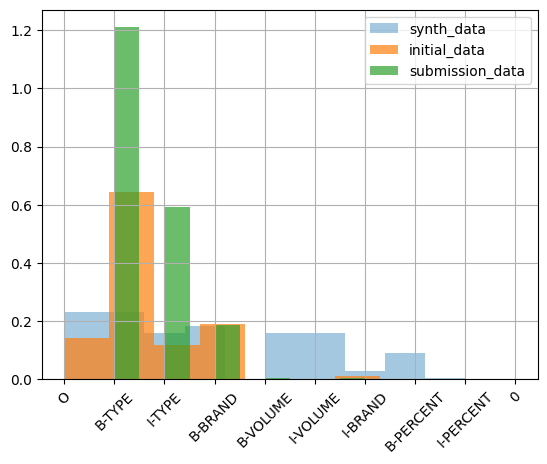

In [36]:
#plt.hist(all_entities_synth_noise_data, label='synth_noise_data', alpha=0.4, density=True);
plt.hist(all_entities_synth_data, label='synth_data', alpha=0.4, density=True);
plt.hist(all_entities_initial_data, label='initial_data', alpha=0.7, density=True);
plt.hist(all_entities_submission_data, label='submission_data', alpha=0.7, density=True);

plt.xticks(rotation=45);
plt.grid()
plt.legend()

Сгенерируем больше данных для volume, brand, percent

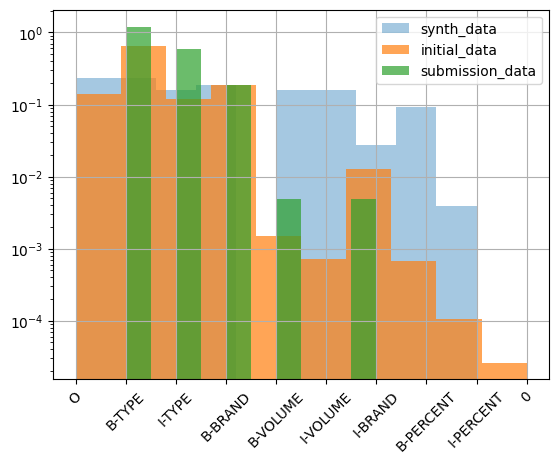

In [37]:
plt.hist(all_entities_synth_data, label='synth_data', alpha=0.4, density=True, log=True);
plt.hist(all_entities_initial_data, label='initial_data', alpha=0.7, density=True, log=True);
plt.hist(all_entities_submission_data, label='submission_data', alpha=0.7, density=True, log=True);

plt.xticks(rotation=45);
plt.grid()
plt.legend()

In [ ]:
all_entities

Нужно две выборки:
 - первая будет из синтетики - в ней будет равномерное распределение классов, 
 - вторая будет такая же, как и в трейне (или другой вариант, такая же, как в тесте)

**На первой выборке будем учить модель, на второй отдельно будем учить модель с другими параметрами**

batch = 192 — слишком большой для finetune BERT без правильной настройки. Большой батч часто ухудшает обобщение.
Рекомендация:  
* per_device_train_batch_size: 8–32 (в зависимости от GPU); если хочешь больший effective batch, используй gradient_accumulation_steps.
* learning_rate: 2e-5 — 5e-5 обычно для BERT-base; если большой батч → уменьшай LR (< 2e-5).
* scheduler: linear warmup (warmup_steps = 0.06 * total_steps) или get_cosine_with_hard_restarts.
* weight_decay = 0.01, AdamW.
* Epochs: 3–5 — нормально, но при большом синтетическом датасете можно:
  * сначала предобучить (or continue train) на синтетике с LR = 5e-5, epochs 1–3;
  * затем тонкая доводка (fine-tune) на чистых 27k с LR = 2e-5 – 1e-5 (2–3 epochs).
Это обычно даёт выигрыш — curriculum / domain-adaptation.
* Оценка данных: синтетика может быть низкого качества. Попробуй:
  * Уменьшить долю плохой синтетики в батче (делай sampling со взвешиванием: реальных примеров больше).
  * Или pretrain на синтетике → finetune на чистом (как выше).
  * Проверить, что шумные O-сущности не «перекашивают» модель на O-класс.

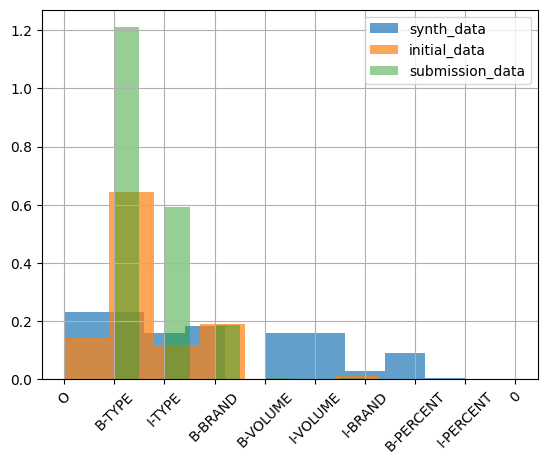

In [47]:
#plt.hist(all_entities_synth_noise_data, label='synth_noise_data', alpha=0.4, density=True);
plt.hist(all_entities_synth_data, label='synth_data', alpha=0.7, density=True);
plt.hist(all_entities_initial_data, label='initial_data', alpha=0.7, density=True);
plt.hist(all_entities_submission_data, label='submission_data', alpha=0.5, density=True);

plt.xticks(rotation=45);
plt.grid()
plt.legend()

In [74]:
new_synth_data = create_labels(samples_num=100000, 
                       noise1_p = 0.25,  
                       noise2_p = 0.25,  
                       type_p = 0.5,  
                       brand_p = 0.5,  
                       percent_p  = 0.5,  
                       volume_p = 0.5,)
new_synth_data = pd.DataFrame(new_synth_data, columns=['sample','annotation'])
#new_synth_data['annotation'] = new_synth_data['annotation'].apply(ast.literal_eval)

In [75]:
all_entities_new_synth_data = [ent[2] for sample in new_synth_data['annotation'] for ent in sample]

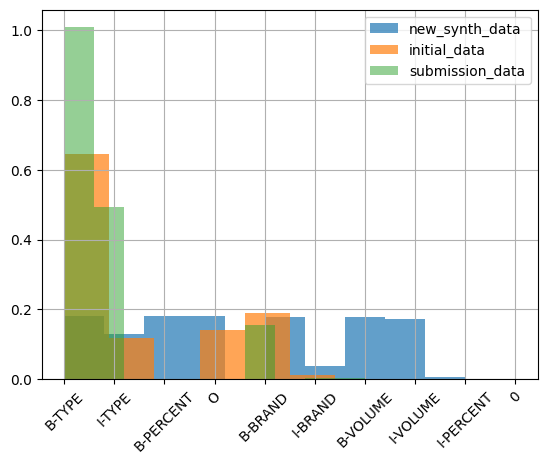

In [76]:
#plt.hist(all_entities_synth_data, label='synth_data', alpha=0.7, density=True);
plt.hist(all_entities_new_synth_data, label='new_synth_data', alpha=0.7, density=True);
plt.hist(all_entities_initial_data, label='initial_data', alpha=0.7, density=True);
plt.hist(all_entities_submission_data, label='submission_data', alpha=0.5, density=True);

plt.xticks(rotation=45);
plt.grid()
plt.legend()

### Data processing

In [ ]:
inv = {v:k for k, v in tokenizer.get_vocab().items()}

In [80]:
def span_to_bio(offset: list[tuple], annotation: list[tuple]):
    res = []
    for elem in offset:
        if elem == (0,0):
            res.append("O")
        else:
            for label in annotation:
                #print(label)
                r = range(label[0], label[1]+1)
                if (elem[0] in r) and (elem[1] in r):
                    res.append(label[2])
    return res

In [79]:
#int_to_bio
bio_to_int

{'B-BRAND': 0,
 'B-TYPE': 1,
 'B-VOLUME': 2,
 'I-PERCENT': 3,
 'B-PERCENT': 4,
 'I-VOLUME': 5,
 'I-TYPE': 6,
 'I-BRAND': 7,
 'O': 8}

In [81]:
def process_data(dataframe: pd.DataFrame, 
                 #int_to_bio: dict, 
                 bio_to_int: dict, 
                 tok: object) -> pd.DataFrame:
    dataframe['tokenized'] = dataframe['sample'].apply(lambda x: tok(x, return_attention_mask=True, return_offsets_mapping=True, return_token_type_ids=True))
    dataframe['input_ids'] = dataframe['tokenized'].apply(lambda x: x['input_ids'])
    dataframe['token_type_ids'] = dataframe['tokenized'].apply(lambda x: x['token_type_ids'])
    dataframe['offset_mapping'] = dataframe['tokenized'].apply(lambda x: x['offset_mapping'])
    dataframe['attention_mask'] = dataframe['tokenized'].apply(lambda x: x['attention_mask'])
    dataframe.drop(columns=['tokenized'], inplace=True)

    X = dataframe[['input_ids','attention_mask', 'token_type_ids']]
    X['BIO'] = dataframe[['annotation','offset_mapping']].apply(lambda x: span_to_bio(offset=x['offset_mapping'], annotation=x['annotation']), axis=1)
    records = X.to_dict(orient='records')
    for i in records:
        while '0' in i['BIO']:
            i['BIO'][i['BIO'].index('0')] = 'O'
    for i in records:
        i['labels'] = [bio_to_int[c_elem] for c_elem in i['BIO']]
        #i.pop('BIO')
    for i in records:
        i.pop('BIO')
    return records

In [84]:
new_synth_data_processed = process_data(dataframe=new_synth_data, bio_to_int=bio_to_int, tok=tokenizer)

C:\Users\jeka_\AppData\Local\Temp\ipykernel_27864\3953103133.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['BIO'] = dataframe[['annotation','offset_mapping']].apply(lambda x: span_to_bio(offset=x['offset_mapping'], annotation=x['annotation']), axis=1)


In [85]:
initial_data_processed = process_data(dataframe=initial_data, bio_to_int=bio_to_int, tok=tokenizer)

C:\Users\jeka_\AppData\Local\Temp\ipykernel_27864\3953103133.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['BIO'] = dataframe[['annotation','offset_mapping']].apply(lambda x: span_to_bio(offset=x['offset_mapping'], annotation=x['annotation']), axis=1)


In [ ]:
#submission_data_processed = process_data(dataframe=submission_data, bio_to_int=bio_to_int, tok=tokenizer)

In [ ]:
submission_data

In [89]:
len(new_synth_data_processed), len(initial_data_processed)

(100000, 27251)

Shuffle

In [ ]:
df = df.sample(df.shape[0], random_state=42)

### Save

In [93]:
with open('g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\data\\new_synth_data_processed.json', 'w') as file:
    json.dump(new_synth_data_processed, file)

with open('g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\data\\initial_data_processed.json', 'w') as file:
    json.dump(initial_data_processed, file)

# with open('max_train_data.json', 'w') as file:
#     json.dump(new_synth_data_processed, file)

### Load

In [94]:
with open('g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\data\\new_synth_data_processed.json', 'r') as file:
    new_synth_data_processed = json.load(file)

with open('g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\data\\initial_data_processed.json', 'r') as file:
    initial_data_processed = json.load(file)

In [95]:
len(new_synth_data_processed), len(initial_data_processed)

(100000, 27251)

### Create dataset

In [97]:
synth_dataset = datasets.Dataset.from_list(new_synth_data_processed)
initial_dataset = datasets.Dataset.from_list(initial_data_processed)

In [98]:
from datasets import DatasetDict

# Разделяем на train/test (например 90% / 10%)
synth_dataset_split = synth_dataset.train_test_split(test_size=0.1, seed=777)
initial_dataset_split = initial_dataset.train_test_split(test_size=0.1, seed=777)

# Превращаем в DatasetDict, чтобы удобно использовать с Trainer
synth_dataset_split = DatasetDict({
    "train": synth_dataset_split["train"],
    "validation": synth_dataset_split["test"]
})

initial_dataset_split = DatasetDict({
    "train": initial_dataset_split["train"],
    "validation": initial_dataset_split["test"]
})

In [99]:
# Он автоматически паддит батчи и проставляет -100 для паддинговых меток
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

## Tune model

In [100]:
model.config

BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-BRAND",
    "1": "B-TYPE",
    "2": "B-VOLUME",
    "3": "I-PERCENT",
    "4": "B-PERCENT",
    "5": "I-VOLUME",
    "6": "I-TYPE",
    "7": "I-BRAND",
    "8": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-BRAND": 0,
    "B-PERCENT": 4,
    "B-TYPE": 1,
    "B-VOLUME": 2,
    "I-BRAND": 7,
    "I-PERCENT": 3,
    "I-TYPE": 6,
    "I-VOLUME": 5,
    "O": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_

In [102]:
int_to_bio

{0: 'B-BRAND',
 1: 'B-TYPE',
 2: 'B-VOLUME',
 3: 'I-PERCENT',
 4: 'B-PERCENT',
 5: 'I-VOLUME',
 6: 'I-TYPE',
 7: 'I-BRAND',
 8: 'O'}

In [104]:
initial_data_processed[0]

{'input_ids': [101, 232, 233, 102],
 'attention_mask': [1, 1, 1, 1],
 'token_type_ids': [0, 0, 0, 0],
 'labels': [8, 8, 8, 8]}

In [106]:
initial_data_processed[2]

{'input_ids': [101, 232, 116609, 10937, 102],
 'attention_mask': [1, 1, 1, 1, 1],
 'token_type_ids': [0, 0, 0, 0, 0],
 'labels': [8, 8, 8, 8, 8]}

In [107]:
initial_data_processed[4]

{'input_ids': [101, 11869, 12181, 102],
 'attention_mask': [1, 1, 1, 1],
 'token_type_ids': [0, 0, 0, 0],
 'labels': [8, 0, 0, 8]}

In [105]:
initial_data

,sample,annotation,input_ids,token_type_ids,offset_mapping,attention_mask
0,aa,"[(0, 2, O)]","[101, 232, 233, 102]","[0, 0, 0, 0]","[(0, 0), (0, 1), (1, 2), (0, 0)]","[1, 1, 1, 1]"
1,aala,"[(0, 4, O)]","[101, 232, 13834, 102]","[0, 0, 0, 0]","[(0, 0), (0, 1), (1, 4), (0, 0)]","[1, 1, 1, 1]"
2,aarcca,"[(0, 6, O)]","[101, 232, 116609, 10937, 102]","[0, 0, 0, 0, 0]","[(0, 0), (0, 1), (1, 4), (4, 6), (0, 0)]","[1, 1, 1, 1, 1]"
3,abon,"[(0, 4, O)]","[101, 11869, 3772, 102]","[0, 0, 0, 0]","[(0, 0), (0, 2), (2, 4), (0, 0)]","[1, 1, 1, 1]"
4,abso,"[(0, 4, B-BRAND)]","[101, 11869, 12181, 102]","[0, 0, 0, 0]","[(0, 0), (0, 2), (2, 4), (0, 0)]","[1, 1, 1, 1]"
...,...,...,...,...,...,...
27246,№1 кофейни,"[(0, 2, B-BRAND), (3, 10, B-TYPE)]","[101, 54220, 31675, 15087, 852, 102]","[0, 0, 0, 0, 0, 0]","[(0, 0), (0, 2), (3, 7), (7, 9), (9, 10), (0, 0)]","[1, 1, 1, 1, 1, 1]"
27247,№1 кофейник,"[(0, 2, B-BRAND), (3, 11, B-TYPE)]","[101, 54220, 31675, 15087, 1520, 102]","[0, 0, 0, 0, 0, 0]","[(0, 0), (0, 2), (3, 7), (7, 9), (9, 11), (0, 0)]","[1, 1, 1, 1, 1, 1]"
27248,№1 пиво,"[(0, 2, B-BRAND), (3, 7, B-TYPE)]","[101, 54220, 42876, 102]","[0, 0, 0, 0]","[(0, 0), (0, 2), (3, 7), (0, 0)]","[1, 1, 1, 1]"
27249,№1 са,"[(0, 2, B-BRAND), (3, 5, B-TYPE)]","[101, 54220, 11380, 102]","[0, 0, 0, 0]","[(0, 0), (0, 2), (3, 5), (0, 0)]","[1, 1, 1, 1]"


In [108]:
id2label = model.config.id2label
label_list = [id2label[i] for i in range(len(id2label))]

In [110]:
model.config.id2label

{0: 'B-BRAND',
 1: 'B-TYPE',
 2: 'B-VOLUME',
 3: 'I-PERCENT',
 4: 'B-PERCENT',
 5: 'I-VOLUME',
 6: 'I-TYPE',
 7: 'I-BRAND',
 8: 'O'}

In [111]:
int_to_bio

{0: 'B-BRAND',
 1: 'B-TYPE',
 2: 'B-VOLUME',
 3: 'I-PERCENT',
 4: 'B-PERCENT',
 5: 'I-VOLUME',
 6: 'I-TYPE',
 7: 'I-BRAND',
 8: 'O'}

In [109]:
label_list

['B-BRAND',
 'B-TYPE',
 'B-VOLUME',
 'I-PERCENT',
 'B-PERCENT',
 'I-VOLUME',
 'I-TYPE',
 'I-BRAND',
 'O']

In [112]:
# Метрики ===
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_labels = [
        [label_list[l] for l in label if l != -100]
        for label in labels
    ]
    true_preds = [
        [label_list[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    return {
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds),
        "accuracy": accuracy_score(true_labels, true_preds),
    }

### Обучение, итерация 1 - pretrain на синтетических метках

batch = 192 — слишком большой для finetune BERT без правильной настройки. Большой батч часто ухудшает обобщение.
Рекомендация:  
* per_device_train_batch_size: 8–32 (в зависимости от GPU); если хочешь больший effective batch, используй gradient_accumulation_steps.
* learning_rate: 2e-5 — 5e-5 обычно для BERT-base; если большой батч → уменьшай LR (< 2e-5).
* scheduler: linear warmup (warmup_steps = 0.06 * total_steps) или get_cosine_with_hard_restarts.
* weight_decay = 0.01, AdamW.
* Epochs: 3–5 — нормально, но при большом синтетическом датасете можно:
  * сначала предобучить (or continue train) на синтетике с LR = 5e-5, epochs 1–3;
  * затем тонкая доводка (fine-tune) на чистых 27k с LR = 2e-5 – 1e-5 (2–3 epochs).
Это обычно даёт выигрыш — curriculum / domain-adaptation.
* Оценка данных: синтетика может быть низкого качества. Попробуй:
  * Уменьшить долю плохой синтетики в батче (делай sampling со взвешиванием: реальных примеров больше).
  * Или pretrain на синтетике → finetune на чистом (как выше).
  * Проверить, что шумные O-сущности не «перекашивают» модель на O-класс.

In [116]:
iter1_training_args = TrainingArguments(
    output_dir="./ner_model_DeepPavlov_iter1",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    #gradient_accumulation_steps=2,
    num_train_epochs=3,

    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.06,                    # 6% шагов на разогрев
    lr_scheduler_type="linear",           # линейный спад LR
    max_grad_norm=1.0,                    # клиппинг градиентов
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    save_total_limit=2,
    dataloader_drop_last=False,

    report_to="tensorboard",
    logging_dir="./logs",                 # директория для логов
    logging_steps=100,                    # частота логирования
    seed=42
)

In [117]:
# # Аргументы обучения
# training_args = TrainingArguments(
#     output_dir="./ner_model_large",
#     eval_strategy="epoch",   # оценка после каждой эпохи
#     save_strategy="epoch",
#     learning_rate=5e-5,
#     per_device_train_batch_size=192,
#     per_device_eval_batch_size=192,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=50,
#     load_best_model_at_end=True,
#     metric_for_best_model="f1",
# )

# Trainer
trainer = Trainer(
    model=model,
    args=iter1_training_args,
    train_dataset=synth_dataset_split["train"],   # предполагаем, что dataset = DatasetDict
    eval_dataset=synth_dataset_split["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Запуск обучения
trainer.train()

# Сохранение модели
trainer.save_model("./ner_model_DeepPavlov_iter1_2112")
tokenizer.save_pretrained("./ner_model_DeepPavlov_iter1_2112")

C:\Users\jeka_\AppData\Local\Temp\ipykernel_27864\1154613221.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.005000,0.003717,0.998078,0.998603,0.998340,0.998967
2,0.003200,0.003687,0.998558,0.998878,0.998718,0.999231
3,0.000600,0.002189,0.999244,0.999336,0.999290,0.999592


('./ner_model_DeepPavlov_iter1_2112\\tokenizer_config.json',
 './ner_model_DeepPavlov_iter1_2112\\special_tokens_map.json',
 './ner_model_DeepPavlov_iter1_2112\\vocab.txt',
 './ner_model_DeepPavlov_iter1_2112\\added_tokens.json',
 './ner_model_DeepPavlov_iter1_2112\\tokenizer.json')

In [132]:
pretrained_model_path = "./ner_model_DeepPavlov_iter1_2112"#"./ner_model_sber/checkpoint-5112"
pretrained_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_path)
#model = AutoModel.from_pretrained("./ner_model_final")
#labels = ["O", "B-TYPE", "I-TYPE", "B-LOC", "I-LOC", ...]

pretrained_model = transformers.AutoModelForTokenClassification.from_pretrained(
    pretrained_model_path
)

In [133]:
label_list

['B-BRAND',
 'B-TYPE',
 'B-VOLUME',
 'I-PERCENT',
 'B-PERCENT',
 'I-VOLUME',
 'I-TYPE',
 'I-BRAND',
 'O']

In [134]:
pretrained_model.config

BertConfig {
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-BRAND",
    "1": "B-TYPE",
    "2": "B-VOLUME",
    "3": "I-PERCENT",
    "4": "B-PERCENT",
    "5": "I-VOLUME",
    "6": "I-TYPE",
    "7": "I-BRAND",
    "8": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-BRAND": 0,
    "B-PERCENT": 4,
    "B-TYPE": 1,
    "B-VOLUME": 2,
    "I-BRAND": 7,
    "I-PERCENT": 3,
    "I-TYPE": 6,
    "I-VOLUME": 5,
    "O": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_typ

### Обучение, итерация 2 - fine-tune на реальных метках от организаторов

batch = 192 — слишком большой для finetune BERT без правильной настройки. Большой батч часто ухудшает обобщение.
Рекомендация:  
* per_device_train_batch_size: 8–32 (в зависимости от GPU); если хочешь больший effective batch, используй gradient_accumulation_steps.
* learning_rate: 2e-5 — 5e-5 обычно для BERT-base; если большой батч → уменьшай LR (< 2e-5).
* scheduler: linear warmup (warmup_steps = 0.06 * total_steps) или get_cosine_with_hard_restarts.
* weight_decay = 0.01, AdamW.
* Epochs: 3–5 — нормально, но при большом синтетическом датасете можно:
  * сначала предобучить (or continue train) на синтетике с LR = 5e-5, epochs 1–3;
  * затем тонкая доводка (fine-tune) на чистых 27k с LR = 2e-5 – 1e-5 (2–3 epochs).
Это обычно даёт выигрыш — curriculum / domain-adaptation.
* Оценка данных: синтетика может быть низкого качества. Попробуй:
  * Уменьшить долю плохой синтетики в батче (делай sampling со взвешиванием: реальных примеров больше).
  * Или pretrain на синтетике → finetune на чистом (как выше).
  * Проверить, что шумные O-сущности не «перекашивают» модель на O-класс.

In [135]:
iter2_training_args = TrainingArguments(
    output_dir="./ner_model_DeepPavlov_iter2",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    #gradient_accumulation_steps=1,
    num_train_epochs=3,

    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,                    # 10% шагов на разогрев
    lr_scheduler_type="linear",           # линейный спад LR
    max_grad_norm=1.0,                    # клиппинг градиентов
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    save_total_limit=2,
    dataloader_drop_last=False,

    report_to="tensorboard",
    logging_dir="./logs",                 # директория для логов
    logging_steps=100,                    # частота логирования
    seed=42
)

In [136]:
# training_args = TrainingArguments(
#     output_dir="./final_model",        # куда сохранять модель
#     overwrite_output_dir=True,         # перезаписывать при повторном запуске

#     evaluation_strategy="epoch",       # оценка после каждой эпохи
#     save_strategy="epoch",             # сохранять после каждой эпохи
#     save_total_limit=2,                # хранить не больше 2 чекпоинтов

#     learning_rate=1e-5,                # ↓ меньше, чем на первом этапе
#     per_device_train_batch_size=16,    # или 32, если хватает GPU
#     per_device_eval_batch_size=32,
#     gradient_accumulation_steps=1,     # можно поднять, если GPU мало памяти
#     num_train_epochs=3,                # 2–4 эпохи достаточно для дообучения
#     weight_decay=0.01,

#     warmup_ratio=0.1,                  # 10% шагов на прогрев LR
#     lr_scheduler_type="linear",

#     logging_dir="./logs",              
#     logging_steps=50,                  # логировать раз в 50 шагов

#     metric_for_best_model="f1",        # твоя метрика (если в compute_metrics считаешь f1)
#     load_best_model_at_end=True,       # брать лучший чекпоинт
#     greater_is_better=True,

#     fp16=True,                         # ускорение и меньше памяти (если GPU поддерживает)
#     seed=42
# )

In [ ]:
pretrained_tokenizer
pretrained_model

In [137]:
data_collator_2nd = DataCollatorForTokenClassification(tokenizer=pretrained_tokenizer)

In [138]:
# # Аргументы обучения
# training_args = TrainingArguments(
#     output_dir="./ner_model_large",
#     eval_strategy="epoch",   # оценка после каждой эпохи
#     save_strategy="epoch",
#     learning_rate=5e-5,
#     per_device_train_batch_size=192,
#     per_device_eval_batch_size=192,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=50,
#     load_best_model_at_end=True,
#     metric_for_best_model="f1",
# )

# Trainer
trainer = Trainer(
    model=pretrained_model,
    args=iter2_training_args,
    train_dataset=initial_dataset_split["train"],   # предполагаем, что dataset = DatasetDict
    eval_dataset=initial_dataset_split["validation"],
    tokenizer=pretrained_tokenizer,
    data_collator=data_collator_2nd,
    compute_metrics=compute_metrics,
)

# Запуск обучения
trainer.train()

# Сохранение модели
trainer.save_model("./ner_model_DeepPavlov_iter2_2126")
tokenizer.save_pretrained("./ner_model_DeepPavlov_iter2_2126")

C:\Users\jeka_\AppData\Local\Temp\ipykernel_27864\3206930119.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.158500,0.152444,0.931719,0.937842,0.934771,0.953192
2,0.112000,0.133890,0.939244,0.958790,0.948916,0.960947
3,0.096500,0.131486,0.944900,0.962623,0.953679,0.964340


('./ner_model_DeepPavlov_iter2_2126\\tokenizer_config.json',
 './ner_model_DeepPavlov_iter2_2126\\special_tokens_map.json',
 './ner_model_DeepPavlov_iter2_2126\\vocab.txt',
 './ner_model_DeepPavlov_iter2_2126\\added_tokens.json',
 './ner_model_DeepPavlov_iter2_2126\\tokenizer.json')

## Load tuned model

In [169]:
new_tuned_model_path = "./ner_model_DeepPavlov_iter2_2126"#"./ner_model_sber/checkpoint-5112"
new_tuned_tokenizer = AutoTokenizer.from_pretrained(new_tuned_model_path, )#truncation=True, max_length=512)
new_tuned_tokenizer.model_max_length = 128
#model = AutoModel.from_pretrained("./ner_model_final")
#labels = ["O", "B-TYPE", "I-TYPE", "B-LOC", "I-LOC", ...]

new_tuned_model = transformers.AutoModelForTokenClassification.from_pretrained(
    new_tuned_model_path
)

In [170]:
new_tuned_model.config

BertConfig {
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-BRAND",
    "1": "B-TYPE",
    "2": "B-VOLUME",
    "3": "I-PERCENT",
    "4": "B-PERCENT",
    "5": "I-VOLUME",
    "6": "I-TYPE",
    "7": "I-BRAND",
    "8": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-BRAND": 0,
    "B-PERCENT": 4,
    "B-TYPE": 1,
    "B-VOLUME": 2,
    "I-BRAND": 7,
    "I-PERCENT": 3,
    "I-TYPE": 6,
    "I-VOLUME": 5,
    "O": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_typ

In [172]:
from transformers import pipeline

ner_pipeline = pipeline(
    "ner",
    model=new_tuned_model,   # путь к сохранённой модели
    tokenizer=new_tuned_tokenizer,
    #aggregation_strategy="simple"  # сгруппировать токены в сущности
    aggregation_strategy="none",
)

Device set to use cuda:0


In [173]:
text = "Сок агуша 2л"
output = ner_pipeline(text)
print(output)

[{'entity': 'B-TYPE', 'score': np.float32(0.99929225), 'index': 1, 'word': 'Сок', 'start': 0, 'end': 3}, {'entity': 'B-BRAND', 'score': np.float32(0.8768344), 'index': 2, 'word': 'аг', 'start': 4, 'end': 6}, {'entity': 'B-BRAND', 'score': np.float32(0.85818267), 'index': 3, 'word': '##уша', 'start': 6, 'end': 9}, {'entity': 'B-VOLUME', 'score': np.float32(0.99927515), 'index': 4, 'word': '2', 'start': 10, 'end': 11}, {'entity': 'B-VOLUME', 'score': np.float32(0.9982621), 'index': 5, 'word': '##л', 'start': 11, 'end': 12}]


In [145]:
text = "Сок агуша 2л"
output = ner_pipeline(text)
print(output)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'B-TYPE', 'score': np.float32(0.99929225), 'index': 1, 'word': 'Сок', 'start': 0, 'end': 3}, {'entity': 'B-BRAND', 'score': np.float32(0.8768344), 'index': 2, 'word': 'аг', 'start': 4, 'end': 6}, {'entity': 'B-BRAND', 'score': np.float32(0.85818267), 'index': 3, 'word': '##уша', 'start': 6, 'end': 9}, {'entity': 'B-VOLUME', 'score': np.float32(0.99927515), 'index': 4, 'word': '2', 'start': 10, 'end': 11}, {'entity': 'B-VOLUME', 'score': np.float32(0.9982621), 'index': 5, 'word': '##л', 'start': 11, 'end': 12}]


## Submit form

In [146]:
subm = pd.read_csv("g:\\My_files\\Programming\\My_projects\\LLM\\Hahaton_mct\\data\\submission.csv", sep=';')

In [150]:
def format_spans(x):
    nums_to_del = []
    for i in range(0, len(x)-1):
        if (x[i]['word'][0] == '#'):
            continue
        if (x[i+1]['word'][0] == '#'):
            nums_to_del.append(i+1)
            x[i]['word'] = x[i]['word'] + x[i+1]['word'].replace('#','')
            x[i]['end'] = x[i+1]['end']
    for i in sorted(nums_to_del, reverse=True):
        x.pop(i)

    # new format
    new = []
    for elem in x:
        new.append((elem['start'], elem['end'], elem['entity']))
    return new

In [148]:
subm['raw_bert_result'] = subm['sample'].apply(lambda x: ner_pipeline(x))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [151]:
subm['result'] = subm['raw_bert_result'].apply(lambda x: format_spans(x))

In [153]:
def merge_spans(spans):
    """
    Объединяет соседние интервалы с одинаковым label (B/I одного типа)
    """
    if not spans:
        return []

    merged = []
    current_start, current_end, current_label = spans[0]

    for start, end, label in spans[1:]:
        if label.split("-")[-1] == current_label.split("-")[-1] and start == current_end:
            # расширяем границу, если тип сущности совпадает и интервалы соприкасаются
            current_end = end
        else:
            merged.append((current_start, current_end, current_label))
            current_start, current_end, current_label = start, end, label

    merged.append((current_start, current_end, current_label))
    return merged

In [154]:
subm['combined_result'] = subm['result'].apply(lambda x: merge_spans(x))

In [157]:
#./ner_model_DeepPavlov_iter2_2126
subm.combined_result.to_csv('sumb_res_DeepPavlov_iter2_2126_2.csv', index=False)